In [1]:
import glob
from astropy import table
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import	multiprocessing as mp
#from plotsettings_py36 import *
from scipy import interpolate
import scipy.optimize
from scipy.optimize import curve_fit
import time

# Functions

In [2]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [3]:
def Alam(lamin):
    
    """
    Module to redden spectrum. Is based on the Cardelli law, i.e. a MW reddening law.
    
    Input: wavelength vector
    Output: Alambda vector
    """

    Rv = 3.08
    
    lam=np.zeros(len(lamin))
    invlammicro=np.zeros(len(lamin))
    redreturn=np.zeros(len(lamin))

    #Convert to microns, then invert to get invlammicro (x)
    for i in range(len(lam)):

        lam[i]=lamin[i]/10000.0
        invlammicro[i]=1/lam[i]

    #IR and Optical

    #For 0.3 < x < 1.1
        if 0.3 <= invlammicro[i]<=1.1:       
            a=0.574 * invlammicro[i] ** 1.61
            b=-0.527 * invlammicro[i] ** 1.61
            redreturn[i] = a + (b/Rv)

    #Optical, NIR

    #For  1.1 < x < 3.3    
        elif 1.1 < invlammicro[i] <= 3.3:
            y=invlammicro[i]-1.82
            a = 1.0 + 0.17699 * y - 0.50447 * y**2 - 0.02427 * y**3 + 0.72085 * y**4 + 0.01979 * y**5 - 0.77530 * y**6 +0.32999 * y**7
            b=1.41338 * y + 2.28305 * y**2 + 1.07233 * y**3 - 5.38434 * y**4 - 0.62251 * y**5 + 5.30260 * y**6 - 2.09002 * y**7
            redreturn[i] = a + (b/Rv)

    # UV and far-UV

    #For 3.3 < x < 5.9
        elif 3.3 < invlammicro[i] < 5.9:    
            a = 1.752 - 0.316 * invlammicro[i] - 0.104 / ((invlammicro[i]-4.67)**2 +0.341)
            b = -3.090 + 1.825 * invlammicro[i] + 1.206 / ((invlammicro[i] - 4.62)**2 + 0.263)
            redreturn[i] = a + (b/Rv)

    #For 5.9 < x < 8   
        elif 5.9 <= invlammicro[i] <= 8.0:
            Fa = -0.04473 * (invlammicro[i] - 5.9)**2 - 0.009779 * (invlammicro[i] - 5.9)**3
            Fb = 0.2130 * (invlammicro[i] - 5.9)**2 + 0.1207 * (invlammicro[i] - 5.9)**3
            a = 1.752 - 0.316 * invlammicro[i] - 0.104 / ((invlammicro[i]-4.67)**2 +0.341) + Fa
            b = -3.090 + 1.825 * invlammicro[i] + 1.206 / ((invlammicro[i] - 4.62)**2 + 0.263) + Fb
            redreturn[i] = a + (b/Rv)


    #For 8 < x < 10    
        elif 8.0 < invlammicro[i] <= 10.0:    
            a = -1.073 - 0.628*(invlammicro[i] - 8.0) + 0.137*(invlammicro[i] - 8.0)**2 - 0.070 * (invlammicro[i] - 8.0)**3
            b = 13.670 + 4.257*(invlammicro[i] - 8.0) - 0.420 * (invlammicro[i]-8.0)**2 + 0.374 * (invlammicro[i] - 8.0)**3
            redreturn[i] = a + (b/Rv)

    return redreturn

In [4]:
def select_templates(DATABASE, TYPES):

    """Selects templates of a given type(s) from a template database
    
    Input: DATEBASE   list of templates
           TYPES      which types should be selected
    
    Output: array of templates of given type(s)
    
    """
    
    database_trunc = list([])
    
    for type in TYPES:
        database_trunc += list([x for x in DATABASE if type in x])
    
    return np.array(database_trunc)

In [83]:
def wrapper_fit(DATABASE):

    """
    Compute the fi
    """
   
    # 1) File i/o
    
    spec_gal    = np.loadtxt(DATABASE['GALAXY'])
    spec_SN     = np.loadtxt(DATABASE['SN'])
    spec_object = np.loadtxt(DATABASE['OBJECT'])
    spec_object[:,1]*=10
    #Redshift change
    #spec_object[:,0]*=(1)
    # 2) Generate an error spectrum of the object spectrum
    """
    spec_object_even = spec_object[:,1][::2]
    spec_object_odd  = spec_object[:,1][1::2]

    if len(spec_object_even) > len(spec_object_odd):
        spec_object_odd += spec_object_even[-1]
    else:
        spec_object_even += spec_object_odd[-1]

    error_spectrum = []
   
    for i in range(len(spec_object_even)):
        error_spectrum.append(abs(spec_object_even[i]-spec_object_odd[i])/2.)
        error_spectrum.append(abs(spec_object_even[i]-spec_object_odd[i])/2.)
    
    if len(error_spectrum) == len(spec_SN):
        error_spectrum=np.array(error_spectrum).reshape((2800, 1))
        spec_object=np.append(spec_object, error_spectrum, axis=1)
    elif len(error_spectrum) > len(spec_SN):
        error_spectrum = np.array(error_spectrum)
        error_spectrum = error_spectrum.reshape((len(error_spectrum), 1))
        error_spectrum = error_spectrum[[np.arange(0,len(spec_object), 1)]]
        spec_object=np.append(spec_object, error_spectrum, axis=1)
    else:
        error_spectrum += error_spectrum[-1]
        error_spectrum=np.array(error_spectrum).reshape((2800, 1))
        spec_object=np.append(spec_object, error_spectrum, axis=1)    
    """
    # 3) Interpolate spectra
    
#    temp_gal[:,1] = temp_gal[:,1]/np.median(temp_gal[:,1][(temp_gal[:,0] > 5000) & (temp_gal[:,0] < 6000)])
#    temp_SN[:,1] = temp_SN[:,1]/np.median(temp_SN[:,1][(temp_SN[:,0] > 5000) & (temp_SN[:,0] < 6000)])
#    temp_object[:,1] = temp_object[:,1]/np.median(temp_object[:,1][(temp_object[:,0] > 5000) & (temp_object[:,0] < 6000)])
    
    spec_gal_interp    = interpolate.interp1d(spec_gal[:,0],    spec_gal[:,1],    bounds_error=False, fill_value=np.nan)
    spec_sn_interp     = interpolate.interp1d(spec_SN[:,0],     spec_SN[:,1],     bounds_error=False, fill_value=np.nan)
    spec_object_interp = interpolate.interp1d(spec_object[:,0], spec_object[:,1], bounds_error=False, fill_value=np.nan)
#    spec_object_err_interp = interpolate.interp1d(spec_object[:,0],     spec_object[:,2],     bounds_error=False, fill_value=np.nan)
    
    # Determine the common wavelength range
    
    lambda_min = max([spec_gal[:,0][0],  spec_SN[:,0][0],  spec_object[:,0][0]])
    lambda_max = min([spec_gal[:,0][-1], spec_SN[:,0][-1], spec_object[:,0][-1]])
    
    # Truncate wavelength interval
    
    lambda_new= spec_object[:,0][ (spec_object[:,0] >= lambda_min) & (spec_object[:,0] <= lambda_max) ]
    
    # 4) Fit function

    def func(x, b):
        return b * spec_sn_interp(x)
    
    """
    def func(x, b, d, z):        
#    def func(x, b, d, c, z):
        #        return d*temp_sn_interp(x/(z+1))*pow(10, Alam(x/(z+1))*c)+b*temp_gal_interp(x/(z+1))
        return d * spec_sn_interp( x / (z+1) ) + b * spec_gal_interp( x / (z+1) )
    """
    # fitting
     
    result = curve_fit(func, lambda_new, spec_object_interp(lambda_new))
    print(result)
    popt   = result[0]
    pcov   = result[1]
    
    # Compute chi^2
    sigma  =1
#    chi2   = np.sum(((spec_object_interp(lambda_new)-func(lambda_new, *popt))/spec_object_err_interp(lambda_new))**2)
    chi2   = np.sum(((spec_object_interp(lambda_new)-func(lambda_new, *popt))/sigma)**2)
    
#    return table.Table(np.array([DATABASE['GALAXY'], DATABASE['SN'], chi2, popt[0], popt[1], popt[2], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2])]), names=('GALAXY', 'SN', 'CHI2', 'CONST_GAL', 'CONST_SN', 'CONST_EXT', 'CONST_GAL_ERR', 'CONST_SN_ERR', 'CONST_EXT_ERR'), dtype=('S100', 'S100', 'f', 'f', 'f', 'f', 'f', 'f', 'f'))
#return table.Table(np.array([DATABASE['OBJECT'], DATABASE['GALAXY'], DATABASE['SN'], chi2, 0, popt[0], 0, popt[1], 0, np.sqrt(pcov[0,0]), 0, np.sqrt(pcov[1,1])]), names=('OBJECT', 'GALAXY', 'SN', 'CHI2', 'CONST_GAL', 'CONST_SN', 'CONST_EXT', 'REDSHIFT', 'CONST_GAL_ERR', 'CONST_SN_ERR', 'CONST_EXT_ERR', 'REDSHIFT_ERR'), dtype=('S100', 'S100', 'S100', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f')) 
    return table.Table(np.array([DATABASE['OBJECT'], DATABASE['GALAXY'], DATABASE['SN'], chi2, 0, popt[0], 0, 0, np.sqrt(pcov[0,0]), 0]), names=('OBJECT', 'GALAXY', 'SN', 'CHI2', 'CONST_GAL', 'CONST_SN', 'CONST_EXT', 'CONST_GAL_ERR', 'CONST_SN_ERR', 'CONST_EXT_ERR'), dtype=('S100', 'S100', 'S100', 'f', 'f', 'f', 'f', 'f', 'f', 'f'))
    

# Read in spectral database

In [84]:
templates_gal = glob.glob('gal/**/*')
templates_gal = [x for x in templates_gal if 'CVS' not in x and 'README' not in x]
templates_gal = np.array(templates_gal)

templates_sn = glob.glob('sne/**/*')
templates_sn = [x for x in templates_sn if 'CVS' not in x and 'README' not in x]
templates_sn = np.array(templates_sn)

templates_dust = np.array([-0.2, 0.1])

In [85]:
templates_gal[:5]

array(['gal/pegase/spec_E.dat', 'gal/pegase/spec_Sbc.dat',
       'gal/pegase/spec_Sb.dat', 'gal/pegase/spec_Im.dat',
       'gal/pegase/spec_Sc.dat'], dtype='<U29')

In [86]:
templates_sn[:5]

array(['sne/II/sn2005db.p86.dat', 'sne/II/sn1997cy.u31.dat',
       'sne/II/sn2005cs.p14.dat', 'sne/II/sn1987a.m84.dat',
       'sne/II/sn2004et.p47.dat'], dtype='<U28')

## Truncate sn templates


In [87]:
templates_sn_trunc = select_templates(templates_sn, ['/II/', '/Ia/'])

# Compute the cartesian product of SN templates, galaxy templates and extinction measurements

In [88]:
cartesian_product_all=cartesian_product(*[templates_gal[:1], templates_sn_trunc, templates_dust[:1]])
cartesian_product_all=table.Table(cartesian_product_all, names=('GALAXY', 'SN', 'DUST'))
cartesian_product_all['OBJECT']=cartesian_product_all['SN'][0]
cartesian_product_all

GALAXY,SN,DUST,OBJECT
str32,str32,str32,str23
gal/pegase/spec_E.dat,sne/II/sn2005db.p86.dat,-0.2,sne/II/sn2005db.p86.dat
gal/pegase/spec_E.dat,sne/II/sn1997cy.u31.dat,-0.2,sne/II/sn2005db.p86.dat
gal/pegase/spec_E.dat,sne/II/sn2005cs.p14.dat,-0.2,sne/II/sn2005db.p86.dat
gal/pegase/spec_E.dat,sne/II/sn1987a.m84.dat,-0.2,sne/II/sn2005db.p86.dat
gal/pegase/spec_E.dat,sne/II/sn2004et.p47.dat,-0.2,sne/II/sn2005db.p86.dat
gal/pegase/spec_E.dat,sne/II/sn2005cs.p01.dat,-0.2,sne/II/sn2005db.p86.dat
gal/pegase/spec_E.dat,sne/II/sn2008ax.p35.dat,-0.2,sne/II/sn2005db.p86.dat
gal/pegase/spec_E.dat,sne/II/sn1986I.p50.dat,-0.2,sne/II/sn2005db.p86.dat
gal/pegase/spec_E.dat,sne/II/sn2004et.p45.dat,-0.2,sne/II/sn2005db.p86.dat


In [89]:
index_array=range(len(cartesian_product_all))
index_array

range(0, 254)

In [90]:
output=wrapper_fit(cartesian_product_all[0])

(array([10.]), array([[0.]]))


In [91]:
output

OBJECT,GALAXY,SN,CHI2,CONST_GAL,CONST_SN,CONST_EXT,CONST_GAL_ERR,CONST_SN_ERR,CONST_EXT_ERR
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32,float32,float32
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/II/sn2005db.p86.dat,0.0,0.0,10.0,0.0,0.0,0.0,0.0


In [92]:
if mp.cpu_count() > 1:
     number_cpu	= mp.cpu_count()/2	# is equal to number of threads x number of physical cpus, e.g. 2x4
else:
    number_cpu	= mp.cpu_count()
number_cpu
pool	= mp.Pool(processes=int(number_cpu)*2)

(array([10.]), array([[0.]]))


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1.]), array([[inf]]))
(array([4.74151659]), array([[0.00310209]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([3.25171342]), array([[0.00412961]]))
(array([1.33671359e+10]), array([[1.4431541e+17]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([101.]), array([[4.14642961e+15]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([2.28469164]), array([[0.00060268]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([0.83085509]), array([[0.00011984]]))
(array([3.78016913]), array([[0.00206596]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([0.08614627])

In [93]:
result	= pool.map(wrapper_fit, cartesian_product_all)

In [94]:
result=table.vstack(result)

In [95]:
result=[wrapper_fit(x) for x in cartesian_product_all]
result=table.vstack(result)

(array([10.]), array([[0.]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.33671359e+10]), array([[1.4431541e+17]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([9.08687135]), array([[0.03139109]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([2.28469164]), array([[0.00060268]]))
(array([1.]), array([[inf]]))
(array([8.67991449]), array([[0.00644308]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([4.61840631]), array([[0.00108553]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([3.73794287e+09]), array([[4.476926e+15]]))
(array([1.]), array([[inf]]))
(array([2.21583831]), array([[0.00409537]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([1.]), array([[inf]]))
(array([3.25171342]), array([[0.00412961]]))
(array([101.]), array([[4.14642961e+15]]))
(array([1.]), array([[inf]]))
(array

In [96]:
result.sort('CHI2')
result[:20]

OBJECT,GALAXY,SN,CHI2,CONST_GAL,CONST_SN,CONST_EXT,CONST_GAL_ERR,CONST_SN_ERR,CONST_EXT_ERR
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32,float32,float32
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/II/sn2005db.p86.dat,0.0,0.0,10.0,0.0,0.0,0.0,0.0
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/II/sn2005db.p15.dat,112.6361,0.0,4.118367,0.0,0.0,0.023514695,0.0
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/II/sn2005db.p40.dat,172.37236,0.0,4.6184063,0.0,0.0,0.032947343,0.0
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/II/sn2005cp.u125.dat,257.5841,0.0,6.7042665,0.0,0.0,0.059322394,0.0
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/II/sn2005cl.p70.dat,263.75723,0.0,8.679914,0.0,0.0,0.080268815,0.0
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/Ia/sn1986g.p44.dat,304.45596,0.0,5.1807703e-12,0.0,0.0,8.4486176e-14,0.0
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/Ia/sn1989b.m03.dat,311.70383,0.0,1.0,0.0,0.0,inf,0.0
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/Ia/sn1989b.m02.dat,311.70383,0.0,1.0,0.0,0.0,inf,0.0
sne/II/sn2005db.p86.dat,gal/pegase/spec_E.dat,sne/II/sn1993W.p99.dat,365.6403,0.0,2.2846916,0.0,0.0,0.024549453,0.0


In [97]:
def visualise_match(DATABASE):

    # File i/o
    
    spec_gal    = np.loadtxt(DATABASE['GALAXY'])
    spec_SN     = np.loadtxt(DATABASE['SN'])
    spec_object = np.loadtxt(DATABASE['OBJECT'])
    spec_object[:,1]*=10

    # Plot data

    bestfit_galaxy = DATABASE['GALAXY'].split('/')[-1]
    bestfit_sn_name = DATABASE['SN'].split('/')[2].split('.')[0]
    bestfit_sn_type = DATABASE['SN'].split('/')[1]
    bestfit_sn_phase = '+' + DATABASE['SN'].split('/')[2].split('.')[1].replace('p', '') if 'p' in DATABASE['SN'].split('/')[2].split('.')[1] else '-' + DATABASE['SN'].split('/')[2].split('.')[1].replace('m', '')
    
    
    plt.figure(figsize=(7*np.sqrt(2), 7))
    
    ax = plt.subplot(111)
    ax.plot(spec_object[:,0], spec_object[:,1], lw=4, label='Input spectrum')
    ax.plot(spec_gal[:,0], DATABASE['CONST_GAL'] * spec_gal[:,1], lw=1, label='Galaxy template: {}'.format(bestfit_galaxy))
    ax.plot(spec_SN[:,0],  DATABASE['CONST_SN']  * spec_SN[:,1],  lw=1, label='SN template: {name} ({type}, {phase} days)'.format(type=bestfit_sn_type, name=bestfit_sn_name, phase=bestfit_sn_phase))
    
    ax.legend()#fontsize=legend_size-4)
    
    ax.set_xlabel('Observed wavelength (\\AA)')
    ax.set_ylabel('Flux density (arbitary units)')
    
    ax.set_xlim(spec_object[0,0]-20, spec_object[-1,0]-20)
    ax.set_ylim(0, max(spec_object[:,1])*1.2)
    
    plt.show()

In [98]:
result[0]['OBJECT']

'sne/II/sn2005db.p86.dat'

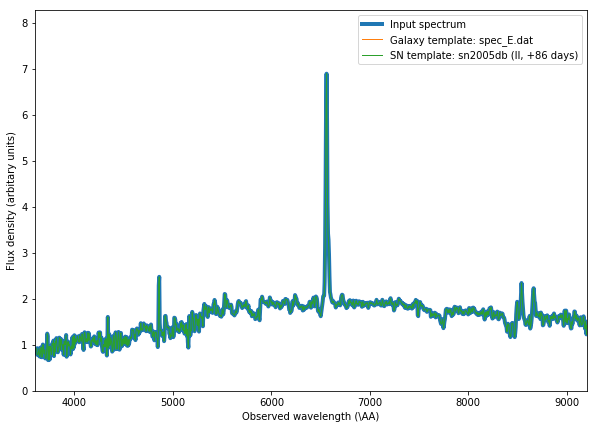

In [99]:
visualise_match(result[0])

In [26]:
np.loadtxt("gal/pegase/spec_E.dat")

array([[9.100e+01, 0.000e+00],
       [9.400e+01, 0.000e+00],
       [9.600e+01, 0.000e+00],
       ...,
       [1.200e+06, 5.360e+21],
       [1.400e+06, 3.158e+21],
       [1.600e+06, 2.032e+21]])